In [1]:
# import necessary packages
import os
import seaborn as sns
import pandas as pd
import pingouin as pg
import numpy as np
from tqdm import tqdm
from IPython.display import display
from random import choices
import pickle

import scipy.stats as st
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mlxtend.evaluate import permutation_test
from matplotlib.colors import ListedColormap

from nilearn.connectome import ConnectivityMeasure

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.covariance import LedoitWolf, EmpiricalCovariance
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV, LeaveOneOut, KFold
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score


In [88]:
# here are the functions which we use later
def load_timeseries_roi(ts_files,subjid_kept,keepgs=True,standardise=True):
    '''
    We load the time series data of subjects who are included.
    :param ts_files: the path to the time series data (output of the
    :param subjid_kept: the IDs of participants (as ordered in the RPN-pipeline)
    :param keepgs: if TRUE, keep the global signal as an additional "ROI"
    :param standardise: if TRUE, standardise the time series upon loading
    :return: ts - the loaded list timeseries files(each is a numpy array), the labels - names of ROIs
    '''
    timeseries = []
    loadedsubjpath = []
    nonloadedsubjpath = []
    for i, f in enumerate(ts_files):
        if i in subjid_kept:
            #print('This is the ordered ID of our included participant:' + str(i)+'\nthis is the file what we read in:\n' + f)
            #print('-'*65)
            if keepgs:
                ts = pd.read_csv(f, sep="\t") #keep the global signal
                #labels = pd.read_csv(ts_files[0], sep="\t").columns
            else:
                ts = pd.read_csv(f, sep="\t").drop('GlobSig', 1).values # delete the global signal
                #labels = pd.read_csv(ts_files[0], sep="\t").columns[1:]

        # standardise timeseries
            if standardise:
                ts = StandardScaler().fit_transform(ts)
            else:
                ts = np.array(ts)
            loadedsubjpath.append(f)
            timeseries.append(ts)
        else:
            nonloadedsubjpath.append(f)
            #print('We do not include participant with:\t'+str(i)+'\torderedID\n who has the following path:'+f)
            #print('-'*65)
    print('We included ' + str(len(loadedsubjpath)) + ' participants')
    labels = pd.read_csv(ts_files[0], sep="\t").columns
    return timeseries, labels

def vectorize_roipairs(labels):
    '''
    The order in the vectorized form of the connectivity matrix is not automatically generated.
    With this custom built function we solve this:
    One has to define the name of the ROIs in the order as it is in the orignial files
    and the function determines the vectorized format of the connectivity matricies
    :param labels: the label output of the load_timesesries_roi function
    :return: the list of all the pair of ROIs in the order of the vectorized connectivity matrix
    '''
    numberofpredictors=int(((len(labels)*len(labels))-len(labels))/2)
    pairofrois=np.zeros(shape=(numberofpredictors,2),dtype=int)
    i=0
    for ff in range(0,len(labels)):
        for gg in range(0,ff):
            pairofrois[i]= [gg,ff]
            i=i+1

    # so call as roilabels[pairofrois[z]]
    vectorzedlabels = []
    listoflabelpairs = []
    for ii in pairofrois:
        vectorzedlabels.append(labels[ii][0]+'+'+labels[ii][1])
        listoflabelpairs.append([labels[ii][0],labels[ii][1]])
    print('The number of connections between regions: '+str(len(listoflabelpairs)))
    return vectorzedlabels, listoflabelpairs

def connectivity_matrix(timeseries, kind='partial correlation',
                        vect=True,covest=LedoitWolf()):
    '''

    :param timeseries: timeseries output of load_timeseries_roi function
    :param kind: the type of correlation between pairs of ROIs.
    :param vect: if TRUE, it returns the vectorized format of the connectivity matrix
    :param covest: the covariance estimate, LedoitWolf is the default option
    :return:
    '''
    # timeseries: as output by load_timeseries
    correlation_measure = ConnectivityMeasure(kind=kind, vectorize=vect, discard_diagonal=True)
    correlation_measure.cov_estimator = covest
    correlation_matrix = correlation_measure.fit_transform(timeseries)
    return correlation_matrix, correlation_measure

def pipe_scale_fsel_ridge_noscaler( fsel=SelectKBest(f_regression),
                          model=Ridge(max_iter=100000),
                        #p_grid = {'fsel__k': [20, 25, 30, 35, 40, 45, 50, 60, 70, 80], 'model__alpha': [.001, .005, .01, .05, .1, .5]} # for fast re-calculation
                        p_grid = {'fsel__k': np.linspace(10, 200, 39,dtype=int), 'model__alpha': [.001, .005, .01, .05, .1, .5, 1, 10]} # exhaustive, takes a lot of time
                          ):
    mymodel = Pipeline(
        [ ('fsel', fsel),
         ('model', model)])
    return mymodel, p_grid

def mytrain(X, y, model, p_grid, nested=False, score="neg_mean_squared_error",model_averaging=True ):

    inner_cv = LeaveOneOut()
    outer_cv = LeaveOneOut() #KFold(n_splits=10)
    predicted = np.array([])

    clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                       scoring=score, verbose=False, return_train_score=False, n_jobs=10,refit=True)
                      #pre_dispatch=6)
    clf.fit(X, y)

    print("**** Non-nested analysis ****")
    print ("** Best hyperparameters: " + str(clf.best_params_))

    print ("** Score on full data as training set:\t" + str(-mean_squared_error(y_pred=clf.best_estimator_.predict(X), y_true=y)))
    print( "** Score on mean as model: " + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
    print ("** Best Non-nested cross-validated score on test:\t" + str(clf.best_score_))

    model=clf.best_estimator_

    print("XXXXX Explained Variance: " + str(1 - clf.best_score_ / -mean_squared_error(np.repeat(y.mean(), len(y)), y)))

    avg_model = None
    all_models = []
    if nested:
        print ("**** Nested analysis ****")

        #nested_scores = cross_val_score(clf, X, y, cv=outer_cv, scoring="explained_variance")
        #print "** Nested Score on test:\t" + str(nested_scores.mean())
        # this above has the same output as this below:

        best_params = []
        predicted = np.zeros(len(y))
        actual = np.zeros(len(y))
        nested_scores_train = np.zeros(outer_cv.get_n_splits(X))
        nested_scores_test = np.zeros(outer_cv.get_n_splits(X))
        nested_scores_test2 = np.zeros(outer_cv.get_n_splits(X))
        i = 0
        avg = []
        # doing the crossval itewrations manually
        print ("model\tinner_cv mean score\touter vc score")
        for train, test in outer_cv.split(X, y):
            clf.fit(X[train], y[train])

            # model avaraging
            #RES, mat, labels = get_full_coef(X[train], clf.best_estimator_, plot=False)
            #avg.append(RES)
            all_models.append(clf.best_estimator_)
            # plot histograms to check distributions
            #bins = np.linspace(-1.5, 1.5, 6)
            #pyplot.hist(y[train], bins, alpha=0.5, label='train')
            #pyplot.hist(y[test], bins, alpha=0.5, label='test')
            #pyplot.legend(loc='upper right')
            #pyplot.show()

            print(str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X[test], y[test])))
            predicted[i] = clf.predict(X[test])
            actual[i] = y[test]

            best_params.append(clf.best_params_)
            nested_scores_train[i] = clf.best_score_
            nested_scores_test[i] = clf.score(X[test], y[test])
            # clf.score is the same as calculating the score to the prediced values of the test dataset:
            #nested_scores_test2[i] = explained_variance_score(y_pred=clf.predict(X[test]), y_true=y[test])
            i = i+1

        print ("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
        print ("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
        print ("** Std score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.std()))
        print ("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
        print ("** Std Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.std()))

        print ("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
        print ("Correlation: " + str(np.corrcoef(actual, predicted)[0,1]))

        avg_model = np.mean(np.array(avg), axis=0)

        #plot the prediction of the outer cv
        fig, ax = plt.subplots()
        ax.scatter(actual, predicted, edgecolors=(0, 0, 0))
       # ax.plot([y.min(), y.max()],
        #           [y.min(), y.max()],
         #          'k--',
          #         lw=2)
        ax.set_xlabel('Observed value')
        ax.set_ylabel('Predicted (Nested LOO)')
        plt.title("Expl. Var.:" +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ) +
        "\nCorrelation: " + str(np.corrcoef(actual, predicted)[0, 1]) )
        plt.show()
    else:
        all_models = [model]
        fig = []

    model.fit(X, y) # fit to whole data

    return model, avg_model, all_models, clf, fig, predicted

def evaluate_crossval_prediction(model, X, y, outfile="", cv=LeaveOneOut(), robust=False):
    predicted = cross_val_predict(model, X, y, cv=cv)
    p_value, r_2, residual, regline = pred_stat(y, predicted, robust=robust)

    expl_var = ( 1- (-mean_squared_error(y_pred=predicted, y_true=y)
                   /
                   -mean_squared_error(np.repeat(y.mean(), len(y)), y) ))*100

    print ("R2=" + "{:.3f}".format(r_2) + "  R=" + "{:.3f}".format(np.sqrt(r_2)) \
          + "   p=" + "{:.6f}".format(p_value) + "  Expl. Var.: " + "{:.1f}".format(expl_var) + "%" \
          + "  Expl. Var.2: " + "{:.1f}".format(explained_variance_score(y_pred=predicted, y_true=y)*100) + "%" \
          + "  MSE=" + "{:.3f}".format(mean_squared_error(y_pred=predicted, y_true=y)) \
          + " RMSE=" + "{:.3f}".format(np.sqrt(mean_squared_error(y_pred=predicted, y_true=y))) \
          + "  MAE=" + "{:.3f}".format(mean_absolute_error(y_pred=predicted, y_true=y)) \
          + " MedAE=" + "{:.3f}".format(median_absolute_error(y_pred=predicted, y_true=y)) \
          + "  R^2=" + "{:.3f}".format(r2_score(y_pred=predicted, y_true=y)))


    plot_prediction(y, predicted, outfile, robust=robust, sd=True,
                         text="$R2$=" + "{:.3f}".format(r_2) +
                              "  p=" + "{:.3f}".format(p_value) +
                              "  Expl. Var.: " + "{:.1f}".format(expl_var) + "%"
                         )
    return predicted

def plot_prediction(observed, predicted, outfile="", covar=[], robust=False, sd=True, text=""):
    color = "black"
    if len(covar):
        g = sns.jointplot(observed, predicted, scatter=False, color=color, kind="reg", robust=robust, x_ci="sd", )
        plt.scatter(observed, predicted,
                    c=covar, cmap=ListedColormap(sns.color_palette(["#5B5BFF","#D73E68"])))
    else:
        g = sns.jointplot(observed, predicted, kind="reg", color=color, robust=robust, x_ci="sd")
    #sns.regplot(observed, predicted, color="b", x_bins=10, x_ci=None)



    if sd:
        xlims=np.array(g.ax_joint.get_xlim())
        if robust:
            res = sm.RLM(predicted, sm.add_constant(observed)).fit()
            coefs = res.params
            residual = res.resid
        else:
            slope, intercept, r_value, p_value, std_err = stats.linregress(observed, predicted)
            coefs=[intercept, slope]
            regline = slope * observed + intercept
            residual = observed - regline

        S = np.sqrt(np.mean(residual**2))
        upper = coefs[1] * xlims + coefs[0] + S/2
        lower = coefs[1] * xlims + coefs[0] - S/2

        plt.plot(xlims, upper, ':', color=color, linewidth=1, alpha=0.3)
        plt.plot(xlims, lower, ':', color=color, linewidth=1, alpha=0.3)

    if text:
        plt.text(np.min(observed) - (np.max(predicted)-np.min(predicted))/3,
                 np.max(predicted) + (np.max(predicted)-np.min(predicted))/3,
                 text, fontsize=10)

    if outfile:
        figure = plt.gcf()
        figure.savefig(outfile, bbox_inches='tight')
        plt.close(figure)
    else:
        plt.show()

def pred_stat(observed, predicted, robust=False):

    # convert to np.array
    observed = np.array(observed)
    predicted = np.array(predicted)

    #EXCLUDE NA-s:
    predicted = predicted[~np.isnan(observed)]
    observed = observed[~np.isnan(observed)]

    if robust:
        res = sm.RLM(observed, sm.add_constant(predicted)).fit()
        p_value = res.pvalues[1]
        regline = res.fittedvalues
        residual = res.sresid

        # this is a pseudo r_squared, see: https://stackoverflow.com/questions/31655196/how-to-get-r-squared-for-robust-regression-rlm-in-statsmodels
        r_2 = sm.WLS(observed, sm.add_constant(predicted), weights=res.weights).fit().rsquared

    else:
        slope, intercept, r_value, p_value, std_err = stats.linregress(observed, predicted)
        regline = slope*observed+intercept
        r_2 = r_value**2
        residual = observed - regline

    return p_value, r_2, residual, regline


## We work with the output of the RPN-signature (see https://spisakt.github.io/RPN-signature/ for details).
### We called it in the following way:
sudo docker run -it --rm -v .../A_data_mri/:/data:ro -v .../rpnresult/:/out tspisak/rpn-signature:latest /data /out participant --keep_all --mem_gb 20 --nthreads 10
### We work with the three outputs:
1. timeseries folder - contains all the participants' time series data from the MIST122 atlas (https://mniopenresearch.org/articles/1-3) (ROIs are columns).
2. motion_summary.csv - the motion summary statistics (mean framewise displacement(FD),	median FD, maximum FD, scrubbed percent (perc_scrubbed))
3. subjectIDs.txt - The mapping between the study subject ID and the ID in the output of the RPN-signature.

In [63]:
# define paths
# load behavior data
col_list1 = ['sub','sex', 'age','hpt','CS','valence','timepoint_phase', 'timepoint_phase2', 'phase']
alldata = pd.read_csv('/home/balint/Documents/Katistudy/C_statistics/alldata.csv',
                      usecols=col_list1,
                      index_col='sub')
# for subjectID (to map the RPN and original subject ID)
# Load the sujectID file from the RPN output to easliy pair the indices with the appropriate participants:
subjID_idx = pd.read_csv('../data_in/subjectsIDs.txt',header=None)
# motion information
motioninf = pd.read_csv("../data_in/motion_summary.csv")

# define path to the timeseries data
ts_directory = "../data_in/timeseries/"
#add label information from the used MIST atlas
labelinf = pd.read_csv('../data_in/MIST_122.csv',sep=';')

In [68]:
# define subject IDs for exclusion and exclusion threshold for mean FD and scrubbed percent
# collect all the particpants subjID who we would like to exclude and include based on the info from the measurement and the motion info
# we exclude three of them because:
# -subj 8 felt asleep in the scanner
# -subj 18 - missing behavior data
# -subj 31 - missing mri data
excl_subnum = [8, 18,31]
#define exclusion thresholds
FDlimit = 0.15
percscrublimit = 25
insert_var = "We used the following thresholds: framewise discplacement < %s, percent of scrubbed volumes < %s "%(FDlimit, percscrublimit)
print(insert_var)

We used the following thresholds: framewise discplacement < 0.15, percent of scrubbed volumes < 25 


In [76]:
# create a dictionary in which the keys are the subject IDs defined in the study and the values are the ids in the RPN(the output simple an increasing
dict_subjID_idx={}
for idx, my_string in enumerate(subjID_idx[0].values):
    dict_subjID_idx[int((my_string.split("func/sub-",1)[1].split('_task',1)[0]))] = idx
# exclude subject based on measurement info
excl_indices = list(dict_subjID_idx[k] for k in excl_subnum if k in dict_subjID_idx.keys())


orderidx_incl = motioninf.loc[(motioninf['meanFD'] < FDlimit) &
                              (motioninf['perc_scrubbed'] < percscrublimit) &
                              (~motioninf['Unnamed: 0'].isin(excl_indices)) ,:].index.values
dict_subjID_idx_incl = {}
dict_subjID_idx_excl = {}
for key, value in dict_subjID_idx.items():
    if value in orderidx_incl:
        dict_subjID_idx_incl[key]=value
    else:
        dict_subjID_idx_excl[key]=value
print('We have MRI data from: ' + str(len(subjID_idx)) + ' participants.')
print('These are the subjects ID who were excluded:\t' + str(list(dict_subjID_idx_excl.keys())) + ' in total: ' + str(len(dict_subjID_idx_excl)))
print('These are the subjects ID who were included:\t' + str(list(dict_subjID_idx_incl.keys())) + ' in total: ' + str(len(dict_subjID_idx_incl)))

print('In total we work with\t'+ str(len(orderidx_incl)) + '\t participants.')
nexclbasedonmotion = len(subjID_idx) - len(excl_indices) - len(orderidx_incl)
print('Number of participant excluded based on the motion parameters(FD>' +str(FDlimit)+ ',scrubbed percent>' +str(percscrublimit)+'):' +str(nexclbasedonmotion))

print('These are the participants subjID whose excluded beforehand:\t' + str(excl_subnum) + 'remember! sub-31 has no MRI data!')

We have MRI data from: 38 participants.
These are the subjects ID who were excluded:	[4, 7, 8, 14, 16, 18, 22, 24, 25, 29, 36, 43, 44] in total: 13
These are the subjects ID who were included:	[3, 5, 9, 12, 15, 17, 19, 20, 21, 23, 27, 28, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 45, 46, 47] in total: 25
In total we work with	25	 participants.
Number of participant excluded based on the motion parameters(FD>0.15,scrubbed percent>25):11
These are the participants subjID whose excluded beforehand:	[8, 18, 31]remember! sub-31 has no MRI data!


In [23]:
# define timeseries path
ts_filelist=os.listdir(ts_directory)
ts_filelist.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
ts_fullpathfs=[]
for ff in ts_filelist:
    ts_fullpathfs.append(os.path.join(ts_directory,ff))
#print('These are the paths to the mri timeseries file:')
#ts_fullpathfs

In [58]:
# load timeseries file only the included participants
ts, labels = load_timeseries_roi(ts_fullpathfs,dict_subjID_idx_incl.values(),
                                                   keepgs=True,standardise=True)

We included 25 participants


In [85]:
# load vectorized ROI pair names
vectorzedlabels, listoflabelpairs = vectorize_roipairs(labels)

The number of connections between regions: 7503


In [89]:
# calculate the connectivity matricies for all the individual who were included.
X, cm = connectivity_matrix(ts,
                            kind='partial correlation',
                            vect=True)
data_conn = pd.DataFrame(X,
            columns=(vectorzedlabels),
            index = dict_subjID_idx_incl.keys())

In [105]:
# Load included participants' valence data.
valencedata = alldata.pivot_table(index=['sub'], columns=['phase','CS','timepoint_phase'],
                                       values='valence').loc[dict_subjID_idx_incl.keys(),:]
# create new index to measure pain-related valence change:
valencedata.loc[:,'y_valpainlearn_acq']=\
(valencedata.loc[:,('acq','pain',4)]-valencedata.loc[:,('hab','pain',0)])-\
(valencedata.loc[:,('acq','minus',4)]- valencedata.loc[:,('hab','minus',0)])

phase             acq                                                        \
CS              minus                    pain                    tone         
timepoint_phase     1     2     3     4     1     2     3     4     1     2   
sub                                                                           
3                36.0   0.0   0.0   0.0   0.0  61.0  62.0  62.0  50.0  57.0   
5                18.0  17.0  14.0  16.0   4.0  17.0  14.0  27.0  42.0  58.0   
9                 9.0  16.0  15.0  17.0  72.0  78.0  78.0  76.0  20.0  19.0   
12               48.0  50.0  51.0  49.0  16.0  12.0  14.0  15.0  70.0  80.0   
15               19.0  20.0  26.0  20.0  73.0  60.0  68.0  68.0  64.0  67.0   
17                0.0   0.0   2.0   1.0   0.0   4.0  50.0  47.0   0.0   0.0   
19               50.0  49.0  53.0  51.0  56.0  69.0  67.0  62.0  63.0  59.0   
20               69.0  40.0  21.0  77.0  61.0  50.0  71.0  86.0  37.0  54.0   
21               14.0   2.0   1.0   0.0  74.0  78.0  83.0  89.0  68.0  75.0   
23               49.0  50.0  50.0  50.0  45.0  50.0  49.0  52.0   0.0   0.0   
27               53.0  47.0  45.0  42.0  41.0  48.0  58.0  53.0  46.0  57.0   
28               25.0  11.0  27.0  23.0  70.0  83.0  75.0  86.0  48.0  18.0   
32                0.0   0.0   0.0   0.0  53.0  69.0  77.0  76.0  65.0  54.0   
33               50.0  29.0  49.0  48.0  58.0  65.0  64.0  60.0  60.0  67.0   
34               53.0  50.0  50.0  50.0  63.0  57.0  59.0  57.0  71.0  73.0   
35               54.0  50.0  48.0  50.0  61.0  41.0  50.0  56.0  63.0  67.0   
37               49.0  58.0  42.0  61.0  42.0  50.0  56.0  65.0  51.0  56.0   
38                7.0   5.0   2.0   0.0  68.0  58.0  56.0  55.0  78.0  78.0   
39               44.0  59.0  57.0  61.0  50.0  57.0  56.0  65.0  58.0  27.0   
40               65.0  58.0  54.0  47.0  33.0  28.0  54.0  46.0  41.0  30.0   
41               60.0  38.0  60.0  58.0  43.0  55.0  72.0  64.0  51.0  63.0   
42               43.0  56.0  49.0  50.0  38.0  78.0  77.0  81.0  38.0  46.0   
45                8.0   5.0   0.0   0.0   7.0  53.0  50.0  70.0  57.0  59.0   
46               69.0  65.0  56.0  66.0  48.0  57.0  58.0  63.0  63.0  62.0   
47               50.0  50.0  54.0  50.0  50.0  50.0  50.0  52.0  50.0  49.0   

phase            ...   ext                                 hab              \
CS               ...  pain              tone             minus  pain  tone   
timepoint_phase  ...     1     2     3     1     2     3     0     0     0   
sub              ...                                                         
3                ...  58.0  25.0   0.0  35.0  50.0   0.0   0.0   0.0   0.0   
5                ...   1.0   6.0   2.0  43.0  35.0  40.0  10.0   5.0  46.0   
9                ...  70.0  68.0  55.0  44.0  47.0  51.0  26.0  33.0  19.0   
12               ...  15.0  11.0  19.0  90.0  83.0  94.0  42.0  17.0  66.0   
15               ...  58.0  50.0  43.0  51.0  51.0  48.0  24.0  61.0  55.0   
17               ...  50.0  50.0  50.0   0.0   0.0   0.0   0.0  49.0   2.0   
19               ...  57.0  59.0  51.0  53.0  51.0  49.0  52.0  53.0  49.0   
20               ...  86.0  79.0  68.0  50.0  38.0  24.0  64.0  29.0  21.0   
21               ...  89.0  65.0  11.0  90.0  35.0   8.0  32.0  53.0  53.0   
23               ...  50.0  51.0  51.0   0.0   0.0   0.0  52.0  48.0  21.0   
27               ...  45.0  51.0  46.0  45.0  32.0  52.0  47.0  29.0  51.0   
28               ...   6.0   3.0   2.0   6.0   7.0   0.0   4.0   2.0   3.0   
32               ...  53.0  48.0  49.0  50.0  48.0  47.0   0.0  49.0  50.0   
33               ...  51.0  49.0  50.0  50.0  49.0  49.0  47.0  36.0  44.0   
34               ...  55.0  54.0  54.0  65.0  59.0  54.0  51.0  52.0  51.0   
35               ...  55.0  54.0  50.0  79.0  61.0  53.0  50.0  44.0  66.0   
37               ...  49.0  56.0  60.0  65.0  61.0  67.0  50.0  20.0  35.0   
38               ...  49.0  50.0  49.0  59.0  49.0  49.0  50.0  49.0  

In [108]:

X_predictor = data_conn.to_numpy()
print('The shape of our predictor matrix:',X_predictor.shape)
yvar = 'y_valpainlearn_acq'
y_predictor = valencedata[yvar].to_numpy()
print('The shape of our outcome variable:', y_predictor.shape)

The shape of our predictor matrix: (25, 7503)
The shape of our outcome variable: (25,)


**** Non-nested analysis ****
** Best hyperparameters: {'fsel__k': 30, 'model__alpha': 0.005}
** Score on full data as training set:	-1.0521850391342011
** Score on mean as model: -543.4399999999999
** Best Non-nested cross-validated score on test:	-320.58734778131196
XXXXX Explained Variance: 0.41007774955595466
**** Nested analysis ****
model	inner_cv mean score	outer vc score
{'fsel__k': 30, 'model__alpha': 0.001} -429.6771098710048 -461.7373455149988
{'fsel__k': 30, 'model__alpha': 0.001} -345.414306580669 -195.2439336596395
{'fsel__k': 40, 'model__alpha': 0.001} -456.8376926602004 -180.93994611304544
{'fsel__k': 40, 'model__alpha': 0.001} -397.2534493944215 -869.8527555363278
{'fsel__k': 40, 'model__alpha': 0.001} -378.6260605637852 -10.695561863718014
{'fsel__k': 30, 'model__alpha': 0.005} -447.9470352525797 -215.18820066625887
{'fsel__k': 20, 'model__alpha': 0.005} -358.4506576529325 -381.3689560370901
{'fsel__k': 25, 'model__alpha': 0.001} -413.22360018788646 -669.2794833271723

/home/balint/PROGRAMS/anaconda3/envs/paintone/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/balint/PROGRAMS/anaconda3/envs/paintone/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


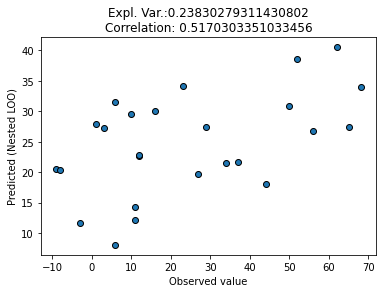

R2=0.509  R=0.714   p=0.000062  Expl. Var.: 41.0%  Expl. Var.2: 41.5%  MSE=320.587 RMSE=17.905  MAE=15.015 MedAE=11.913  R^2=0.410


/home/balint/PROGRAMS/anaconda3/envs/paintone/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


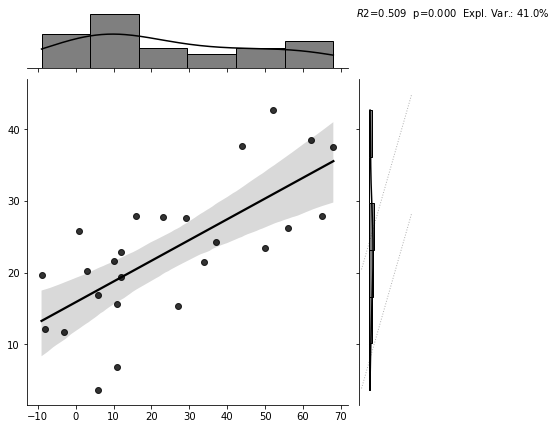

In [112]:
X_ridg = X_predictor
y_ridg = y_predictor

mymodel, p_grid = pipe_scale_fsel_ridge_noscaler()
m, avg_model, all_models, mycrossval, myfig, nestedpredictedvals = mytrain(X_ridg, y_ridg, mymodel, p_grid,
                                                                              nested=True,
                                                                              score='neg_mean_squared_error')
myprediction = evaluate_crossval_prediction(m,X_ridg, y_ridg,outfile=[])

In [ ]:
# save the model
#filename = '/home/balint/CODE/Fear-conditiong-and-Rsns/data_out/finalmodel/finale_model_M1.sav'
#pickle.dump(m, open(filename, 'wb'))
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)

In [31]:
# get the most important connections from our model
finalemodel = m
print('This is the main model. The connections are listed in strength order.')

zip_dict_labelnames=zip(list(labelinf['label']),list(labelinf['name']))
dict_labelnames=dict(zip_dict_labelnames)
# add global signal by hand
dict_labelnames['GlobSig'] = 'Global Signal'
#define the connections in our model, this include the short name of the connection pair and the strenght in the model
connections = pd.DataFrame(list((listoflabelpairs[i],finalemodel[1].coef_[idx]) for idx,i in enumerate(finalemodel[0].get_support(indices=True))),
                           columns=['conn','strenght'])
#print(connections.head())
print('the total number of predictive connections:'+str(len(connections)))
connections

This is the main model. The connections are listed in strength order.
the total number of predictive connections:30


,conn,strenght
0,"[CERCR1, CER6_d]",19.936245
1,"[R_CERCR2_p, L_IPlob.1]",-20.626237
2,"[CER7b_m, PRC_d.1]",-12.664019
3,"[PRC_v, R_MFgyr_a]",22.326984
4,"[CER9_d, FP]",2.825834
5,"[POsul_v, SPlob.1]",20.670183
6,"[SPlob.1, L_MFgyr_pr]",6.547995
7,"[L_DVIS_v, R_PORB]",-36.199498
8,"[R_IPsul, L_IPsul]",33.612956
9,"[R_ANGgyr, DVIS_vl]",-15.201830


In [33]:
# this part only
dict_roivalues = dict(zip(list(labelinf['roi']),list(labelinf['label'])))
#add global signal by hand
dict_roivalues[123]='GlobSig'
# we have to play around a little as the short names of certain ROIs are in the list two times because they are neighbouring areas in the MIST122 atlas.
# (e.g. the superior parietal lobule is the 1st and 76th ROI as well, but that two region anatomical coordinates are differ a bit(see the MIST122 table for detail)
for row, ind in enumerate(connections['conn']):
    if ind[0][-2:]=='.1':
        print(ind)
        connections.loc[row,'region1'] = dict_labelnames[ind[0][:-2]]
        connections.loc[row,'roival_region1'] = [list(dict_roivalues.keys())[i] for i, n in enumerate(list(dict_roivalues.values())) if n == ind[0][:-2]][1]
    else:
        connections.loc[row,'region1'] = dict_labelnames[ind[0]]
        connections.loc[row,'roival_region1'] = [list(dict_roivalues.keys())[i] for i, n in enumerate(list(dict_roivalues.values())) if n == ind[0]][0]
    if ind[1][-2:]=='.1':
        print(ind)
        connections.loc[row,'region2'] = dict_labelnames[ind[1][:-2]]
        connections.loc[row,'roival_region2'] = [list(dict_roivalues.keys())[i] for i, n in enumerate(list(dict_roivalues.values())) if n == ind[1][:-2]][1]
    else:
        connections.loc[row,'region2'] = dict_labelnames[ind[1]]
        connections.loc[row,'roival_region2'] = [list(dict_roivalues.keys())[i] for i, n in enumerate(list(dict_roivalues.values())) if n == ind[1]][0]

ordered_connections = connections.reindex(connections.strenght.abs().sort_values(ascending=False).index)
ordered_connections

['R_CERCR2_p', 'L_IPlob.1']
['CER7b_m', 'PRC_d.1']
['POsul_v', 'SPlob.1']
['SPlob.1', 'L_MFgyr_pr']
['L_IPlob.1', 'IMsul']


,conn,strenght,region1,roival_region1,region2,roival_region2
13,"[PINS_v, L_MOTnet_dl]",45.758609,POSTERIOR_INSULA_ventral,21.0,left_SOMATOMOTOR_NETWORK_dorsolateral,8.0
29,"[THAL_d, VVISnet_m]",-45.549817,THALAMUS_dorsal,31.0,VENTRAL_VISUAL_NETWORK_medial,40.0
10,"[CER7b_m, COLsul]",41.789489,CEREBELLUM_VIIb_medial,18.0,COLLATERAL_SULCUS,79.0
7,"[L_DVIS_v, R_PORB]",-36.199498,left_DORSAL_VISUAL_STREAM_ventral,50.0,right_PARS_ORBITALIS,92.0
8,"[R_IPsul, L_IPsul]",33.612956,right_INTRAPARIETAL_SULCUS,20.0,left_INTRAPARIETAL_SULCUS,74.0
25,"[PUT_p, PVISnet_dm]",-29.782826,PUTAMEN_posterior,25.0,POSTERIOR_VISUAL_NETWORK_dorsomedial,16.0
27,"[CER5, MVISnet_ad]",-29.406609,CEREBELLUM_I-V,48.0,MEDIAL_VISUAL_NETWORK_anterodorsal,19.0
26,"[L_CERCR2_a, MVISnet_ad]",28.867435,left_CEREBELLUM_CRUSII_anterior,54.0,MEDIAL_VISUAL_NETWORK_anterodorsal,19.0
21,"[L_IPlob, MDVISnet_p]",28.798373,left_INFERIOR_PARIETAL_LOBULE,4.0,MEDIODORSAL_VISUAL_NETWORK_posterior,57.0
22,"[PCcor, LVISnet_vp]",-28.120602,POSTERIOR_CINGULATE_CORTEX,24.0,LATERAL_VISUAL_NETWORK_ventroposterior,81.0
